In [1]:
import sys
import os
import subprocess
from six import string_types
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display
import cv2
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras import regularizers
%matplotlib inline

Using TensorFlow backend.


In [2]:
PLANET_KAGGLE_ROOT = os.path.abspath("/Users/sunchenxi/Desktop/lab/kaggle/amazon/")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

### read train set labels

In [3]:
#读取train set标签
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)

In [4]:
labels_df

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0
5,train_5,haze primary water,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,train_6,agriculture clear cultivation primary water,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0
7,train_7,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,train_8,agriculture clear cultivation primary,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
9,train_9,agriculture clear cultivation primary road,0,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0


### get 10000 images and labels as the training set

In [27]:
images=[0]*10000
for i in range(0,10000):
    images[i]  = cv2.imread(PLANET_KAGGLE_ROOT+"/train-jpg/train_"+str(i)+".jpg")

In [6]:
a=labels_df.values[:,3:5]
b=labels_df.values[:,6:11]
c=labels_df.values[:,13:]
labels=np.hstack((a,b))
labels=np.hstack((labels,c))

### add some rare images

In [9]:
#get image name
def sample_to_fname(sample_df, row_idx, suffix='jpg'):
    '''Given a dataframe of sampled images, get the
    corresponding filename.'''
    fname = sample_df.get_value(sample_df.index[row_idx], 'image_name')
    return '{}.{}'.format(fname, suffix)
def sample_images(tags, n=None):
    """Randomly sample n images with the specified tags."""
    condition = True
    if isinstance(tags, string_types): #tag是否是string类型
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & labels_df[tag] == 1
    if n is not None:
        return labels_df[condition].sample(n)
    else:
        return labels_df[condition]


In [10]:
blow_down=sample_images(['blow_down'],98)
fname1=[0]*98
for i in range(98):
    fname1[i]= sample_to_fname(blow_down, i)#获得了文件名
blow_down_img=[cv2.imread(PLANET_KAGGLE_ROOT+'/train-jpg/'+ img) for img in fname1]
a=blow_down.values[:,3:5]
b=blow_down.values[:,6:11]
c=blow_down.values[:,13:]
blow_down_label=np.hstack((a,b))
blow_down_label=np.hstack((blow_down_label,c))

In [12]:
conventional_mine=sample_images(['conventional_mine'],100)
fname2=[0]*100
for i in range(100):
    fname2[i]= sample_to_fname(conventional_mine, i)#
conventional_mine_img=[cv2.imread(PLANET_KAGGLE_ROOT+'/train-jpg/'+ img) for img in fname2]
a=conventional_mine.values[:,3:5]
b=conventional_mine.values[:,6:11]
c=conventional_mine.values[:,13:]
conventional_mine_label=np.hstack((a,b))
conventional_mine_label=np.hstack((conventional_mine_label,c))

In [16]:
slash_burn=sample_images(['slash_burn'],100)
fname3=[0]*100
for i in range(100):
    fname3[i]= sample_to_fname(slash_burn, i)#
slash_burn_img=[cv2.imread(PLANET_KAGGLE_ROOT+'/train-jpg/'+ img) for img in fname3]
a=slash_burn.values[:,3:5]
b=slash_burn.values[:,6:11]
c=slash_burn.values[:,13:]
slash_burn_label=np.hstack((a,b))
slash_burn_label=np.hstack((slash_burn_label,c))

In [17]:
blooming=sample_images(['blooming'],100)
fname4=[0]*100
for i in range(100):
    fname4[i]= sample_to_fname(blooming, i)#
blooming_img=[cv2.imread(PLANET_KAGGLE_ROOT+'/train-jpg/'+ img) for img in fname4]
a=blooming.values[:,3:5]
b=blooming.values[:,6:11]
c=blooming.values[:,13:]
blooming_label=np.hstack((a,b))
blooming_label=np.hstack((blooming_label,c))

In [18]:
artisinal_mine=sample_images(['artisinal_mine'],100)
fname5=[0]*100
for i in range(100):
    fname5[i]= sample_to_fname(artisinal_mine, i)#
artisinal_mine_img=[cv2.imread(PLANET_KAGGLE_ROOT+'/train-jpg/'+ img) for img in fname5]
a=artisinal_mine.values[:,3:5]
b=artisinal_mine.values[:,6:11]
c=artisinal_mine.values[:,13:]
artisinal_mine_label=np.hstack((a,b))
artisinal_mine_label=np.hstack((artisinal_mine_label,c))

In [19]:
selective_logging=sample_images(['selective_logging'],100)
fname6=[0]*100
for i in range(100):
    fname6[i]= sample_to_fname(selective_logging, i)#
selective_logging_img=[cv2.imread(PLANET_KAGGLE_ROOT+'/train-jpg/'+ img) for img in fname6]
a=selective_logging.values[:,3:5]
b=selective_logging.values[:,6:11]
c=selective_logging.values[:,13:]
selective_logging_label=np.hstack((a,b))
selective_logging_label=np.hstack((selective_logging_label,c))

In [21]:
bare_ground=sample_images(['bare_ground'],200)
fname7=[0]*200
for i in range(200):
    fname7[i]= sample_to_fname(bare_ground, i)#
bare_ground_img=[cv2.imread(PLANET_KAGGLE_ROOT+'/train-jpg/'+ img) for img in fname7]
a=bare_ground.values[:,3:5]
b=bare_ground.values[:,6:11]
c=bare_ground.values[:,13:]
bare_ground_label=np.hstack((a,b))
bare_ground_label=np.hstack((bare_ground_label,c))

### train_x,train_y

In [31]:
allimg=images+blow_down_img+conventional_mine_img+slash_burn_img+blooming_img+artisinal_mine_img+selective_logging_img+bare_ground_img
resized_images = [np.reshape(cv2.resize(img,(64,64),interpolation=cv2.INTER_AREA), [1,64,64,3]) for img in allimg]
alllabel=np.vstack((labels[:10000],blow_down_label,conventional_mine_label,slash_burn_label,blooming_label,artisinal_mine_label,selective_logging_label,bare_ground_label))

In [294]:
len(resized_images)

10798

In [35]:
train_x=np.vstack((resized_images))
train_y=alllabel

### training the model

In [39]:
optimizer = RMSprop(lr=1e-5)
objective = 'binary_crossentropy'
def convnet():
    
    model = Sequential()

    model.add(Convolution2D(32, kernel_size=(3, 3), padding='same', input_shape=(64, 64, 3), activation='relu'))
    model.add(Convolution2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.5))

    model.add(Dense(13))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = convnet()

In [40]:
early_stopping = EarlyStopping(monitor='val_loss', patience=16, verbose=1, mode='auto')
# history = LossHistory()
fitting=model.fit(train_x, train_y, batch_size=64, epochs=1024,
          validation_split=0.25, verbose=1, shuffle=True, callbacks=[early_stopping])

Train on 8098 samples, validate on 2700 samples
Epoch 1/1024
8098/8098 [==============================] - 470s - loss: 7.6149 - acc: 0.8287 - val_loss: 7.2820 - val_acc: 0.8940
Epoch 2/1024
8098/8098 [==============================] - 455s - loss: 7.0797 - acc: 0.8732 - val_loss: 6.8241 - val_acc: 0.8939
Epoch 3/1024
8098/8098 [==============================] - 448s - loss: 6.6129 - acc: 0.8862 - val_loss: 6.3875 - val_acc: 0.8936
Epoch 4/1024
8098/8098 [==============================] - 431s - loss: 6.1724 - acc: 0.8960 - val_loss: 5.9700 - val_acc: 0.8915
Epoch 5/1024
8098/8098 [==============================] - 431s - loss: 5.7641 - acc: 0.9012 - val_loss: 5.5910 - val_acc: 0.8913
Epoch 6/1024
8098/8098 [==============================] - 432s - loss: 5.3887 - acc: 0.9062 - val_loss: 5.2449 - val_acc: 0.8915
Epoch 7/1024
8098/8098 [==============================] - 443s - loss: 5.0427 - acc: 0.9073 - val_loss: 4.9099 - val_acc: 0.8916
Epoch 8/1024
8098/8098 [=========================

8098/8098 [==============================] - 463s - loss: 0.1797 - acc: 0.9390 - val_loss: 0.3136 - val_acc: 0.8939
Epoch 126/1024
8098/8098 [==============================] - 391s - loss: 0.1789 - acc: 0.9388 - val_loss: 0.2833 - val_acc: 0.9023
Epoch 127/1024
8098/8098 [==============================] - 391s - loss: 0.1788 - acc: 0.9391 - val_loss: 0.2847 - val_acc: 0.9034
Epoch 128/1024
8098/8098 [==============================] - 391s - loss: 0.1781 - acc: 0.9392 - val_loss: 0.2872 - val_acc: 0.9034
Epoch 129/1024
8098/8098 [==============================] - 391s - loss: 0.1777 - acc: 0.9396 - val_loss: 0.2887 - val_acc: 0.8962
Epoch 130/1024
8098/8098 [==============================] - 391s - loss: 0.1759 - acc: 0.9396 - val_loss: 0.3109 - val_acc: 0.9032
Epoch 131/1024
8098/8098 [==============================] - 397s - loss: 0.1756 - acc: 0.9398 - val_loss: 0.2818 - val_acc: 0.9018
Epoch 132/1024
8098/8098 [==============================] - 398s - loss: 0.1742 - acc: 0.9402 - va

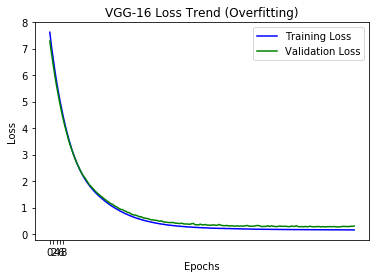

In [41]:
loss = fitting.history['loss']
val_loss = fitting.history['val_loss']
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend (Overfitting)')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

### save model

In [42]:
from keras.models import load_model

In [43]:
model.save('/Users/sunchenxi/Desktop/lab/code/planet/my_model.h5') 

### predict test-jpg

In [155]:
test_img=[0]*40669
for i in range(0,40669):
    test_img[i]=cv2.imread(PLANET_KAGGLE_ROOT+"/test-jpg/test_"+str(i)+".jpg")

In [156]:
#test_x teat images
test_x = [np.reshape(cv2.resize(img,(64,64),interpolation=cv2.INTER_AREA),[1,64,64,3]) for img in test_img]

In [157]:
test=np.vstack((test_x))

In [167]:
result=model.predict(test)

#### predicting test labels in test_y

In [489]:
#test_y: predict tags
test_y=[] 
for i in range(40669): 
    test_y.append([]) 
for i in range(0,40669):
    if result[i][0]>0.5:
        test_y[i].append("primary")
    if result[i][1]>0.5:
        test_y[i].append("agriculture")
    if result[i][2]>0.5:
        test_y[i].append("water")
    if result[i][3]>0.5:
        test_y[i].append("habitation")
    if result[i][4]>0.5:
        test_y[i].append("road")
    if result[i][5]>0.5:
        test_y[i].append("cultivation")
    if result[i][6]>0.1:
        test_y[i].append("slash_burn")
    if result[i][7]>0.1:
        test_y[i].append("conventional_mine")
    if result[i][8]>0.1:
        test_y[i].append("bare_ground")
    if result[i][9]>0.1:
        test_y[i].append("artisinal_mine")
    if result[i][10]>0.1:
        test_y[i].append("blooming")
    if result[i][11]>0.1:
        test_y[i].append("selective_logging")
    if result[i][12]>0.1:
        test_y[i].append("blow_down")        

In [490]:
name=[0]*40669
for n in range(0,40669):
    name[n]="test_"+str(n)+".jpg"

In [505]:
final_df = pd.DataFrame({'image_name':name,'tags':test_y})
final_df.head(10)

,image_name,tags
0,test_0.jpg,[primary]
1,test_1.jpg,[primary]
2,test_2.jpg,[primary]
3,test_3.jpg,[primary]
4,test_4.jpg,[primary]
5,test_5.jpg,[primary]
6,test_6.jpg,"[primary, agriculture]"
7,test_7.jpg,"[primary, agriculture, habitation, road]"
8,test_8.jpg,[primary]
9,test_9.jpg,[primary]


In [500]:
#prediction
test_y[40642]

['primary', 'agriculture', 'road']

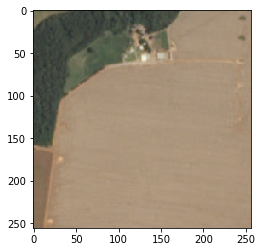

In [499]:
numofimg=40642
test_img=mpimg.imread(PLANET_KAGGLE_ROOT+"/test-jpg/test_"+str(numofimg)+".jpg")
plt.imshow(test_img)

### f2_score for each single label in train set

In [353]:
trainset_img=[0]*1000
n=10000
for t in range(0,1000):
    trainset_img[t]=cv2.imread(PLANET_KAGGLE_ROOT+"/train-jpg/train_"+str(n)+".jpg")
    n+=1

In [354]:
trainset_x = [np.reshape(cv2.resize(img,(64,64),interpolation=cv2.INTER_AREA),[1,64,64,3]) for img in trainset_img]

In [355]:
trainset=np.vstack((trainset_x))

In [357]:
trainset_result=model.predict(trainset)

In [364]:
real_y=labels[10000:11000]

In [461]:
#trainset_y predict labels

trainset_y=[] 
for i in range(1000): 
    trainset_y.append([]) 
for i in range(0,1000):
    if trainset_result[i][0]>0.5:
        trainset_y[i].append(1)
    else:
        trainset_y[i].append(0)
        
    if trainset_result[i][1]>0.1:
         trainset_y[i].append(1)
    else:
        trainset_y[i].append(0)
        
    if trainset_result[i][2]>0.1:
        trainset_y[i].append(1)
    else:
        trainset_y[i].append(0)
        
    if trainset_result[i][3]>0.1:
        trainset_y[i].append(1)
    else:
        trainset_y[i].append(0)
        
    if trainset_result[i][4]>0.1:
        trainset_y[i].append(1)
    else:
        trainset_y[i].append(0)
        
    if trainset_result[i][5]>0.1:
        trainset_y[i].append(1)
    else:
        trainset_y[i].append(0)
        
    if trainset_result[i][6]>0.1:
        trainset_y[i].append(1)
    else:
        trainset_y[i].append(0)
        
    if trainset_result[i][7]>0.1:
        trainset_y[i].append(1)
    else:
        trainset_y[i].append(0)
        
    if trainset_result[i][8]>0.1:
        trainset_y[i].append(1)
    else:
        trainset_y[i].append(0)
        
    if trainset_result[i][8]>0.1:
        trainset_y[i].append(1)
    else:
        trainset_y[i].append(0)
        
    if trainset_result[i][9]>0.1:
        trainset_y[i].append(1)
    else:
        trainset_y[i].append(0)
        
    if trainset_result[i][10]>0.1:
        trainset_y[i].append(1)
    else:
        trainset_y[i].append(0)
        
    if trainset_result[i][11]>0.1:
        trainset_y[i].append(1)
    else:
        trainset_y[i].append(0)
        
    if trainset_result[i][12]>0.1:
        trainset_y[i].append(1)
    else:
        trainset_y[i].append(0)

In [462]:
#real_y=alllabel[9798:]

### f2－score for each single label in training set

In [463]:
f2=[] 
for i in range(1000): 
    f2.append([]) 
    
F2_score0=0.0
F2_score1=0.0
F2_score2=0.0
F2_score3=0.0
F2_score4=0.0
F2_score5=0.0
F2_score6=0.0
F2_score7=0.0
F2_score8=0.0
F2_score9=0.0
F2_score10=0.0
F2_score11=0.0
F2_score12=0.0

precision0=0.0
precision1=0.0
precision2=0.0
precision3=0.0
precision4=0.0
precision5=0.0
precision6=0.0
precision7=0.0
precision8=0.0
precision9=0.0
precision10=0.0
precision11=0.0
precision12=0.0

recall0=0.0
recall1=0.0
recall2=0.0
recall3=0.0
recall4=0.0
recall5=0.0
recall6=0.0
recall7=0.0
recall8=0.0
recall9=0.0
recall10=0.0
recall11=0.0
recall12=0.0

true_positive0=0.0
false_positive0=0.0
false_negative0=0.0

true_positive1=0.0
false_positive1=0.0
false_negative1=0.0

true_positive2=0.0
false_positive2=0.0
false_negative2=0.0

true_positive3=0.0
false_positive3=0.0
false_negative3=0.0

true_positive4=0.0
false_positive4=0.0
false_negative4=0.0

true_positive5=0.0
false_positive5=0.0
false_negative5=0.0

true_positive6=0.0
false_positive6=0.0
false_negative6=0.0

true_positive7=0.0
false_positive7=0.0
false_negative7=0.0

true_positive8=0.0
false_positive8=0.0
false_negative8=0.0

true_positive9=0.0
false_positive9=0.0
false_negative9=0.0

true_positive10=0.0
false_positive10=0.0
false_negative10=0.0

true_positive11=0.0
false_positive11=0.0
false_negative11=0.0

true_positive12=0.0
false_positive12=0.0
false_negative12=0.0

for i in range(len(trainset_y)-1):
    
    if trainset_y[i][0]==real_y[i][0]==1:
            true_positive0+=1
    elif trainset_y[i][0]==1 and real_y[i][0]==0:
             false_positive0+=1
    elif trainset_y[i][0]==0 and real_y[i][0]==1:
            false_negative0+=1
            
    if trainset_y[i][1]==real_y[i][1]==1:
            true_positive1+=1
    elif trainset_y[i][1]==1 and real_y[i][1]==0:
            false_positive1+=1
    elif trainset_y[i][1]==0 and real_y[i][1]==1:
            false_negative1+=1
        
    if trainset_y[i][2]==real_y[i][2]==1:
            true_positive2+=1
    elif trainset_y[i][2]==1 and real_y[i][2]==0:
            false_positive2+=1
    elif trainset_y[i][2]==0 and real_y[i][2]==1:
            false_negative2+=1
      
    if trainset_y[i][3]==real_y[i][3]==1:
            true_positive3+=1
    elif trainset_y[i][3]==1 and real_y[i][3]==0:
            false_positive3+=1
    elif trainset_y[i][3]==0 and real_y[i][3]==1:
            false_negative3+=1
    
    if trainset_y[i][4]==real_y[i][4]==1:
            true_positive4+=1
    elif trainset_y[i][4]==1 and real_y[i][4]==0:
            false_positive4+=1
    elif trainset_y[i][4]==0 and real_y[i][4]==1:
            false_negative4+=1
    
    if trainset_y[i][5]==real_y[i][5]==1:
            true_positive5+=1
    elif trainset_y[i][5]==1 and real_y[i][5]==0:
            false_positive5+=1
    elif trainset_y[i][5]==0 and real_y[i][5]==1:
            false_negative5+=1
    
    if trainset_y[i][6]==real_y[i][6]==1:
            true_positive6+=1
    elif trainset_y[i][6]==1 and real_y[i][6]==0:
            false_positive6+=1
    elif trainset_y[i][6]==0 and real_y[i][6]==1:
            false_negative6+=1
    
    if trainset_y[i][7]==real_y[i][7]==1:
            true_positive7+=1
    elif trainset_y[i][7]==1 and real_y[i][7]==0:
            false_positive7+=1
    elif trainset_y[i][7]==0 and real_y[i][7]==1:
            false_negative7+=1
    
    if trainset_y[i][8]==real_y[i][8]==1:
            true_positive8+=1
    elif trainset_y[i][8]==1 and real_y[i][8]==0:
            false_positive8+=1
    elif trainset_y[i][8]==0 and real_y[i][8]==1:
            false_negative8+=1
    
    if trainset_y[i][9]==real_y[i][9]==1:
            true_positive9+=1
    elif trainset_y[i][9]==1 and real_y[i][9]==0:
            false_positive9+=1
    elif trainset_y[i][9]==0 and real_y[i][9]==1:
            false_negative9+=1
    
    if trainset_y[i][10]==real_y[i][10]==1:
            true_positive10+=1
    elif trainset_y[i][10]==1 and real_y[i][10]==0:
            false_positive10+=1
    elif trainset_y[i][10]==0 and real_y[i][10]==1:
            false_negative10+=1
            
    if trainset_y[i][11]==real_y[i][11]==1:
            true_positive11+=1
    elif trainset_y[i][11]==1 and real_y[i][11]==0:
            false_positive11+=1
    elif trainset_y[i][11]==0 and real_y[i][11]==1:
            false_negative11+=1
    
    if trainset_y[i][12]==real_y[i][12]==1:
            true_positive12+=1
    elif trainset_y[i][12]==1 and real_y[i][12]==0:
            false_positive12+=1
    elif trainset_y[i][12]==0 and real_y[i][12]==1:
            false_negative12+=1
print true_positive6
print false_positive6
print false_negative6
print " "
print true_positive7
print false_positive7
print false_negative7
print " "
print true_positive8
print false_positive8
print false_negative8
print " "
print true_positive9
print false_positive9
print false_negative9
print " "
print true_positive10
print false_positive10
print false_negative10
print " "
print true_positive11
print false_positive11
print false_negative11
print " "
print true_positive12
print false_positive12
print false_negative12

if true_positive0+false_positive0 !=0:   
    precision0=true_positive0/(true_positive0+false_positive0)
if true_positive1+false_positive1!=0:
    precision1=true_positive1/(true_positive1+false_positive1)
if true_positive2+false_positive2!=0:
    precision2=true_positive2/(true_positive2+false_positive2)
if  true_positive3+false_positive3!=0:
    precision3=true_positive3/(true_positive3+false_positive3)
if true_positive4+false_positive4!=0:
    precision4=true_positive4/(true_positive4+false_positive4)
if true_positive5+false_positive5!=0:
    precision5=true_positive5/(true_positive5+false_positive5)
if true_positive6+false_positive6!=0:
    precision6=true_positive6/(true_positive6+false_positive6)
if true_positive7+false_positive7!=0:
    precision7=true_positive7/(true_positive7+false_positive7)
if true_positive8+false_positive8!=0:
    precision8=true_positive8/(true_positive8+false_positive8)
if true_positive9+false_positive9!=0:
    precision9=true_positive9/(true_positive9+false_positive9)
if true_positive10+false_positive10!=0:
    precision10=true_positive10/(true_positive10+false_positive10)
if true_positive11+false_positive11!=0:
    precision11=true_positive11/(true_positive11+false_positive11)
if true_positive12+false_positive12!=0: 
    precision12=true_positive12/(true_positive12+false_positive12)

if true_positive0+false_negative0!=0:  
    recall0=true_positive0/(true_positive0+false_negative0)
if true_positive1+false_negative1!=0:
    recall1=true_positive1/(true_positive1+false_negative1)
if true_positive2+false_negative2!=0:
    recall2=true_positive2/(true_positive2+false_negative2)
if true_positive3+false_negative3!=0:
    recall3=true_positive3/(true_positive3+false_negative3)
if true_positive4+false_negative4!=0:
    recall4=true_positive4/(true_positive4+false_negative4)
if true_positive5+false_negative5!=0:
    recall5=true_positive5/(true_positive5+false_negative5)
if true_positive6+false_negative6!=0:
    recall6=true_positive6/(true_positive6+false_negative6)
if true_positive7+false_negative7!=0:
    recall7=true_positive7/(true_positive7+false_negative7)
if true_positive8+false_negative8!=0:
    recall8=true_positive8/(true_positive8+false_negative8)
if true_positive9+false_negative9!=0:
    recall9=true_positive9/(true_positive9+false_negative9)
if true_positive10+false_negative10!=0:
    recall10=true_positive10/(true_positive10+false_negative10)
if true_positive11+false_negative11!=0:
    recall11=true_positive11/(true_positive11+false_negative11)
if true_positive12+false_negative12!=0: 
    recall12=true_positive12/(true_positive12+false_negative12)


F2_score0=5*precision0*recall0/(4*precision0+recall0)
F2_score1=5*precision1*recall1/(4*precision1+recall1)
F2_score2=5*precision2*recall2/(4*precision2+recall2)
F2_score3=5*precision3*recall3/(4*precision3+recall3)
F2_score4=5*precision4*recall4/(4*precision4+recall4)

F2_score5=5*precision5*recall5/(4*precision5+recall5)
#F2_score6=5*precision6*recall6/(4*precision6+recall6)
#F2_score7=5*precision7*recall7/(4*precision7+recall7)
F2_score8=5*precision8*recall8/(4*precision8+recall8)
F2_score9=5*precision9*recall9/(4*precision9+recall9)
#F2_score10=5*precision10*recall10/(4*precision10+recall10)
#F2_score11=5*precision11*recall11/(4*precision11+recall11)
F2_score12=5*precision12*recall12/(4*precision12+recall12)

0.0
0.0
5.0
 
0.0
0.0
2.0
 
1.0
14.0
20.0
 
2.0
13.0
6.0
 
0.0
10.0
11.0
 
0.0
0.0
8.0
 
1.0
2.0
3.0


In [465]:
F2_score0,F2_score1,F2_score2,F2_score3,F2_score4,F2_score5,F2_score6,F2_score7,F2_score8,F2_score9,F2_score10,F2_score11,F2_score12

(0.9861291720849589,
 0.7994100294985251,
 0.5821635012386457,
 0.5781758957654723,
 0.7438345266507558,
 0.4844961240310078,
 0.0,
 0.0,
 0.050505050505050504,
 0.2127659574468085,
 0.0,
 0.0,
 0.2631578947368421)

### acc of allright onewrong twowrong

In [507]:
acc=[] 
for i in range(1000): 
    acc.append([]) 
accuracy1=0.0#预测对的单标签／全部标签
accuracy2=0.0#全部预测正确
accuracy3=0.0#预测错一个
accuracy4=0.0#预测错两个

for i in range(len(trainset_y)-1):
    right=0
    pre1real0=0
    pre0real1=0
    accu=0
    for j in range(0,len(trainset_y[i])-1):
        if trainset_y[i][j]==real_y[i][j]==1:
                right+=1
        if trainset_y[i][j]==1 and real_y[i][j]==0:
                pre1real0+=1
        if trainset_y[i][j]==0 and real_y[i][j]==1:
                pre0real1+=1
    acc[i].append(right)
    acc[i].append(pre1real0)
    acc[i].append(pre0real1)
    if right+pre1real0+pre0real1==0:
        acc[i].append(0)
        accuracy+=0 
    else:
        acc[i].append(float(right)/float(right+pre1real0+pre0real1)) 
        accuracy1+=float(right)/float(right+pre1real0+pre0real1)
    if pre1real0==0 and pre0real1==0:
        accuracy2+=1
    if (pre1real0==0 and pre0real1==0) or (pre1real0==0 and pre0real1==1) or (pre1real0==1 and pre0real1==0):
        accuracy3+=1
    if (pre1real0+pre0real1==0) or (pre1real0+pre0real1==1) or (pre1real0+pre0real1==2):
        accuracy4+=1

In [521]:
accuracy1/1000,accuracy2/1000,accuracy3/1000,accuracy4/1000

(0.8449480158730158, 0.705, 0.865, 0.919)

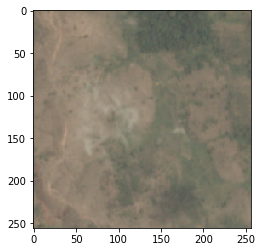

In [522]:
test_img=mpimg.imread(PLANET_KAGGLE_ROOT+"/train-jpg/train_8634.jpg")
plt.imshow(test_img)